In [1]:
nEpochs=25  # orig, longer training
# nEpochs=3  # quick testing during development

# Select one (and only one) model to train
USE_CGAN = False
USE_CVAE = True
USE_CVAECGAN = False

# Extract model name based on boolean value above
model_name = ""
if USE_CGAN:
    model_name += "cgan"
elif USE_CVAE:
    model_name += "cvae"
elif USE_CVAECGAN:
    model_name += "cvaecgan"

# Double check model name is valid
if model_name not in {"cgan", "cvae", "cvaecgan"}:
    raise Exception("Double check you are only using one model. The current model name is invalid")

## 1. Import 3rd party libraries 

In [2]:
import os
os.chdir('/project/nanocourse/SWE_OOP/train03/se/Module_2_Materials/mod2/HPO')
import session_info
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

try:
    os.environ["CUDA_VISIBLE_DEVICES"]="1"
    gpus = tf.config.list_physical_devices("GPU")
    print(gpus)
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0], 
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3300)]
    )
except:
    Warning("Unable To configure Tensorflow GPU")
    
# Import our own classes 
from vaegan.data import MNIST
from vaegan.conditional.callbacks import GenerateImagesConditional, SaveImagesConditional
from vaegan.gan_SOLUTIONS import ConditionalGAN
from vaegan.vae_SOLUTIONS import ConditionalVAE
from vaegan.conditional.models import ConditionalVAECGAN

#session_info.show()

2025-05-30 09:57:26.906695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748617047.624953   15471 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748617047.948189   15471 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748617049.329097   15471 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748617049.329137   15471 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748617049.329140   15471 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 3. Show some our data

I0000 00:00:1748617070.145756   15471 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3300 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:82:00.0, compute capability: 6.0


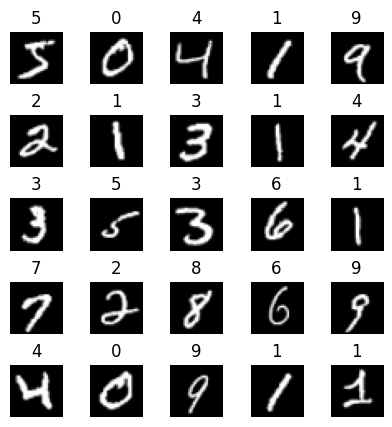

In [3]:
# Create output directory if it doesn't exist yet.
output_dir = './outputs/mnist' + f"_hpo_{model_name}"
os.makedirs(output_dir, exist_ok=True)
    
# Instantiate the MNIST class containing our training data.
data = MNIST()

# One-hot encode the labels
n_classes = int(data.labels_train.max() + 1)
labels_onehot = tf.one_hot(data.labels_train, 
                           depth=n_classes,
                           dtype=tf.float32).numpy()

# Show some example images and their labels.
data.show_example_images(os.path.join(output_dir, 'example_images.png'))

## 4. Construct the model using the python class you completed

In [4]:
# Create the model. Note that we're using mostly the default arguments, but this is
# where you might want to play around with different loss weights.
tf.random.set_seed(1234)
hpo_params = {
    'n_latent_dims' : 4,
    'learning_rate': 0.001,
    'encoder_params' : {
        'conv_layer_units' : [16,64],
        'conv_layer_kernel_size' : [4,4,4,4],
        'conv_layer_strides' : [(1,1), (2,2)],
        'conv_layer_activation_function' : ['relu','relu'],
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },
    'decoder_params' : {'conv_layer_units' : [16,64],
        'conv_layer_kernel_size' : [4,4],
        'conv_layer_strides' : [(1,1), (2,2)],
        'conv_layer_activation_function' : ['relu','relu'],
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },
    'generator_params' : {
        'generator_conv_layer_units' : [128,128],
        'generator_conv_layer_kernel_size' : [4,4],
        'generator_conv_layer_strides' : [(2,2), (2,2)],
        'generator_conv_layer_activation_functions' : [tf.nn.leaky_relu,tf.nn.leaky_relu],
        'discriminator_dense_layer_units' : [128],
        'generator_dense_layer_units' : [],
    },
    'discriminator_params' : {
        'discriminator_conv_layer_units' : [32,64],
        'discriminator_conv_layer_kernel_size' : [4,4],
        'discriminator_conv_layer_strides' : [(1,1), (2,2)],
        'discriminator_conv_layer_activation_functions' : ['relu','relu'],
        'discriminator_dense_layer_units' : [],
        'generator_dense_layer_units' : [],
    }
}

if USE_CGAN:
    model = ConditionalGAN(n_classes=n_classes,
                                 n_latent_dims = hpo_params['n_latent_dims'],
                                 generator_params = hpo_params['generator_params'],
                                 discriminator_params = hpo_params['discriminator_params'])
if USE_CVAE:
    model = ConditionalVAE(n_classes=n_classes, 
                            n_latent_dims = hpo_params['n_latent_dims'],
                            encoder_params = hpo_params['encoder_params'],
                            decoder_params = hpo_params['decoder_params'],
    )
if USE_CVAECGAN:
    model = ConditionalVAECGAN(adv_loss_weight=10., 
                            n_classes=n_classes,
                            n_latent_dims = hpo_params['n_latent_dims'],
                            encoder_params=hpo_params['encoder_params'],
                            decoder_params=hpo_params['decoder_params'],
                            discriminator_params=hpo_params['discriminator_params']
    )


# This step tells Keras to compute the explicit output shapes of each layer.
# Otherwise, the layers will have dynamic/variable output shapes which is not
# compatible with saving and loading.

# # All three models will use this input structure
# model.compute_output_shape([(None, 32, 32, 1), (None, n_classes)])
# if USE_CVAE or USE_CVAECGAN:
#     model.decoder.compute_output_shape((None, n_classes + model.n_latent_dims))
# if USE_CGAN or USE_CVAECGAN:
#     model.discriminator.compute_output_shape((None, 32, 32, 1))

Loaded version: vaegan.vae_SOLUTIONS
Loaded version: vaegan.vae_SOLUTIONS


In [5]:
print("=== OVERALL MODEL ====")
model.summary()

if USE_CGAN:
    print("=== GENERATOR SUBMODEL ====")
    gen_in = tf.keras.layers.Input((model.n_latent_dims+model.n_classes,))
    gen_out  = model.generator.call(gen_in) 
    gen = tf.keras.Model(gen_in, gen_out) 
    gen.summary()
    print("=== DISCRIMINATOR SUBMODEL ====")
    disc_in = tf.keras.layers.Input(model.image_shape) 
    disc_out  = model.discriminator.call(disc_in) 
    disc = tf.keras.Model(disc_in, disc_out) 
    disc.summary()
    
if USE_CVAE:
    print("=== ENCODER SUBMODEL ====")
    enc_in = tf.keras.layers.Input((32,32,1 + model.n_classes)) # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
    enc_out  = model.encoder.call(enc_in) 
    enc = tf.keras.Model(enc_in, enc_out) 
    enc.summary()
    print("=== DECODER SUBMODEL ====")
    dec_in = tf.keras.layers.Input((model.n_latent_dims+model.n_classes,)) 
    dec_out  = model.decoder.call(dec_in) 
    dec = tf.keras.Model(dec_in, dec_out) 
    dec.summary()

if USE_CVAECGAN:
    print("=== ENCODER SUBMODEL ====")
    enc_in = tf.keras.layers.Input((32,32,1 + model.n_classes)) # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
    enc_out  = model.encoder.call(enc_in) 
    enc = tf.keras.Model(enc_in, enc_out) 
    enc.summary()
    print("=== DECODER SUBMODEL ====")
    dec_in = tf.keras.layers.Input((model.n_latent_dims + model.n_classes,)) 
    dec_out  = model.decoder.call(dec_in) 
    dec = tf.keras.Model(dec_in, dec_out) 
    dec.summary()
    print("=== DISCRIMINATOR SUBMODEL ====")
    disc_in = tf.keras.layers.Input(model.image_shape) 
    disc_out  = model.discriminator.call(disc_in) 
    disc = tf.keras.Model(disc_in, disc_out) 
    disc.summary()


=== OVERALL MODEL ====


Model: "cvae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

=== ENCODER SUBMODEL ====


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 32, 32,    │      2,832 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 32, 32,    │         64 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 32, 32,    │          0 │ bn0[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 16, 16,    │     16,448 │ relu0[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 16, 16,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (Activation)  │ (None, 16, 16,    │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ relu1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense0 (Dense)      │ (None, 128)       │  2,097,280 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_mean (Dense)  │ (None, 4)         │        516 │ dense0[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_logvar        │ (None, 4)         │        516 │ dense0[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,117,912 (8.08 MB)

 Trainable params: 2,117,752 (8.08 MB)

 Non-trainable params: 160 (640.00 B)

=== DECODER SUBMODEL ====


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_to_conv (Dense)           │ (None, 16384)          │       245,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv1 (Conv2DTranspose)        │ (None, 32, 32, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv0 (Conv2DTranspose)        │ (None, 32, 32, 16)     │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 32, 32, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu0 (Activation)              │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_out (Conv2D)               │ (None, 32, 32, 1)      │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid_out (Activation)        │ (None, 32, 32, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,097 (1.25 MB)

 Trainable params: 327,937 (1.25 MB)

 Non-trainable params: 160 (640.00 B)

In [6]:
_ = model([data.images_train[:1], labels_onehot[:1]])

I0000 00:00:1748571887.369318   11803 cuda_dnn.cc:529] Loaded cuDNN version 90300


## 6. Compile the model 

In [7]:
# Compile the model with an optimizer. The learning rate of the optimizer can be
# specified here. Normally, this is also where you would select a loss function
# and any metrics. However, our custom model defines the loss functions inside
# its __init__ constructor, so we don't need to do that here. 

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hpo_params['learning_rate']), run_eagerly=True)

# Instantiate our custom callback to save a few example reconstructions and
# generated images after each epoch.
if USE_CGAN:
    save_images_callback = GenerateImagesConditional(output_dir=output_dir, 
                                                    model=model,
                                                    example_labels=labels_onehot[:10],
                                                    n_generated_images=10,
                                                    n_latent_dims=model.n_latent_dims)
elif USE_CVAE or USE_CVAECGAN:
    save_images_callback = SaveImagesConditional(output_dir=output_dir, 
                                                model=model,
                                                example_images=data.images_train[:10],
                                                example_labels=labels_onehot[:10],
                                                n_generated_images=10,
                                                n_latent_dims=model.n_latent_dims)



## 7. Train (fit) the model on the data 

In [8]:
# Train the model. Just like any off-the-shelf Keras model, we just call fit.
# Under the hood, Keras will call the train_step method of our custom subclass
# on each mini-batch and automatically loop through the training data. It will
# take care of all the details, like converting numpy arrays to tensors, showing
# a progress bar, and tracking the loss over the epochs.
logs = model.fit([data.images_train, labels_onehot],
                 batch_size=128,
                 epochs=nEpochs,
                 callbacks=[save_images_callback])

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 107s 223ms/step - kl_loss: 110.8711 - recon_loss: 72.1192 - total_loss: 182.9904
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 98s 208ms/step - kl_loss: 6.9857 - recon_loss: 34.7251 - total_loss: 41.7109
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 208ms/step - kl_loss: 6.0200 - recon_loss: 30.3860 - total_loss: 36.4060
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 98s 208ms/step - kl_loss: 5.7844 - recon_loss: 27.5685 - total_loss: 33.3529
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 108s 229ms/step - kl_loss: 5.8223 - recon_loss: 26.0711 - total_loss: 31.8934
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - kl_loss: 5.8662 - recon_loss: 25.2904 - total_loss: 31.1566
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 96s 205ms/step - kl_loss: 5.8934 - recon_loss: 24.6903 - total_loss: 30.5838
Epoch 8/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - kl_loss: 5.9065 - recon_loss: 24.3280 - total_loss: 30.2344
Epoch 9/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 99s 211ms/step - kl

## 8. Training saves results to disk, now also plot training curves

In [11]:
logs.history.keys()

dict_keys(['kl_loss', 'recon_loss', 'total_loss'])

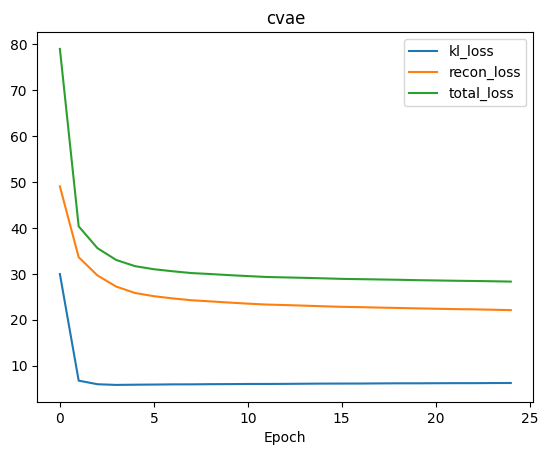

In [12]:
# Plot the training curves, which are stored in logs.history as a dict. Keys of
# this dict are the metric names, while the corresponding values are arrays.
fig, ax = plt.subplots()

for loss_name in ['enc_loss', 'dec_loss', 'disc_loss', 'gen_loss', 'kl_loss', 'recon_loss', 'total_loss']:
    if loss_name in logs.history.keys():
        loss_values = logs.history[loss_name]
        x = np.arange(len(loss_values))
        ax.plot(x, loss_values, label=loss_name)
        
ax.legend()
ax.set_xlabel('Epoch')
ax.set_title(model_name)
fig.savefig(os.path.join(output_dir, 'training_curves.png'), transparent=False)
# fig.show()

# Save the model 
model.save(os.path.join(output_dir, model_name+'.keras'))
import pickle
with open(os.path.join(output_dir, model_name+'.logs'), 'wb') as f:
    pickle.dump(logs.history, f)


# HPO Exercise: Your Turn!
- Take the code from above, and implement a grid search over at least 2 hyper parameters (try at least 3 different values for each hyper parameter)
  - Train each model for at least 20 epochs. 
  - You can modify both hyperparameters at the same time, or perform two completely separate sequential tunings. 
  - You can find some suggested hyperparameter ranges / values in the table below:

Hyperparameter | [min value, max value]
----------------|-----------------------
Number of latent dims: |   [2, 128]
Number of Convolutional layers: |     [1, 6]
Number of convolutional layer units:|     [4, 256]
Convolutional kernel size: | [2, 5]
Convolutional layer activation functions (choose): |  ['relu', 'elu', 'linear', tf.nn.leaky_relu, 'softmax', 'sigmoid']
Dense layer units: | [4, 256]
Learning Rate:  | [0.01, 0.000001]


In [4]:
n_classes = int(data.labels_train.max() + 1)
test_labels_onehot = tf.one_hot(data.labels_test, depth=n_classes, dtype=tf.float32).numpy()

In [5]:
nEpochs = 20
default_hpo_params = {
    'n_latent_dims' : 4,
    'learning_rate': 0.001,
    'encoder_params' : {
        'conv_layer_units' : [16,64],
        'conv_layer_kernel_size' : [4,4,4,4],
        'conv_layer_strides' : [(1,1), (2,2)],
        'conv_layer_activation_function' : ['relu','relu'],
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },
    'decoder_params' : {'conv_layer_units' : [16,64],
        'conv_layer_kernel_size' : [4,4],
        'conv_layer_strides' : [(1,1), (2,2)],
        'conv_layer_activation_function' : ['relu','relu'],
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },}

method = 'cvae'
output_base_dir = f'outputs/hpo_{method}_gridSearch'
if os.path.exists(output_base_dir)==False:
    os.mkdir(output_base_dir)

In [ ]:
import pickle
# Instantiate a container with the hyperparameter(s) you want to test
hpo_params_optionDict = {
    'n_latent_dims': [32],
    'learning_rate': [1e-3],
    'conv_layer_kernel_size': [4]
    # 'n_latent_dims': [4, 16, 32],
    # 'learning_rate': [1e-3, 1e-4, 1e-5],
    # 'conv_layer_kernel_size': [3, 4]
}

import itertools
from copy import deepcopy
hparam_names = sorted(hpo_params_optionDict.keys())
hparam_combinations = list(itertools.product(*(hpo_params_optionDict[name] for name in hparam_names)))

all_evaluation_results = {}
batch_size = 512
for i, combo in enumerate(hparam_combinations):
    current_hparams = dict(zip(hparam_names, combo))
    model_name = 'cvae_'
    hpo_params = deepcopy(default_hpo_params)
    for key in current_hparams.keys():
        if key in ['n_latent_dims', 'learning_rate']:
            hpo_params[key] = current_hparams[key]
        elif key == 'conv_layer_kernel_size':
            hpo_params['encoder_params'][key] = [current_hparams[key]]*len(hpo_params['encoder_params']['conv_layer_units'])
        model_name += f'{key}_{current_hparams[key]}_'
    print(model_name)
    output_dir = os.path.join(output_base_dir, model_name)
    if os.path.exists(output_dir)==False:
        os.mkdir(output_dir)
    print(output_dir)
    
    tf.random.set_seed(1234)
    model = ConditionalVAE(n_classes=n_classes, 
                            n_latent_dims = hpo_params['n_latent_dims'],
                            encoder_params = hpo_params['encoder_params'],
                            decoder_params = hpo_params['decoder_params'],
                            name = model_name
    )

    enc_in = tf.keras.layers.Input((32,32,1 + model.n_classes)) # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
    enc_out  = model.encoder.call(enc_in) 
    enc = tf.keras.Model(enc_in, enc_out) 
    # enc.summary()
    # print("=== DECODER SUBMODEL ====")
    dec_in = tf.keras.layers.Input((model.n_latent_dims+model.n_classes,)) 
    dec_out  = model.decoder.call(dec_in) 
    dec = tf.keras.Model(dec_in, dec_out) 
    # dec.summary()

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hpo_params['learning_rate']), run_eagerly=True)

    # Fit model to the data
    save_images_callback = SaveImagesConditional(output_dir=output_dir, 
                                                    model=model,
                                                    example_images=data.images_train[:10],
                                                    example_labels=labels_onehot[:10],
                                                    n_generated_images=10,
                                                    n_latent_dims=model.n_latent_dims)

    logs = model.fit([data.images_train, labels_onehot],
                    batch_size=128,
                    epochs=nEpochs,
                    callbacks=[save_images_callback])

    evaluation_results_list = model.evaluate([data.images_test, test_labels_onehot],
                                             batch_size=128, verbose=1)

    evaluation_metrics_dict = {name: value for name, value in zip(model.metrics_names, evaluation_results_list)}
    print(f"Evaluation Results for {model_name}: {evaluation_metrics_dict}")

    all_evaluation_results[model_name] = evaluation_metrics_dict

    # Plot the training curves for the model
    fig, ax = plt.subplots()

    for loss_name in ['enc_loss', 'dec_loss', 'disc_loss', 'gen_loss', 'kl_loss', 'recon_loss', 'total_loss']:
        if loss_name in logs.history.keys():
            loss_values = logs.history[loss_name]
            x = np.arange(len(loss_values))
            ax.plot(x, loss_values, label=loss_name)
            
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_title(model_name)
    fig.savefig(os.path.join(output_dir, 'training_curves.png'), transparent=False)
    # fig.show()

    # Save the model 
    model.save(os.path.join(output_dir, f'{model_name}.keras'))
    logs_save_path = os.path.join(output_dir, f'{model_name}.logs')
    full_logs = logs.history
    full_logs['evaluation_results'] = evaluation_metrics_dict
    with open(logs_save_path, 'wb') as f:
        pickle.dump(full_logs, f)


In [ ]:
with open(os.path.join(output_base_dir, 'all_evaluation_results.pkl'), 'wb') as f:
    pickle.dump(all_evaluation_results, f)

Text(0.5, 1.0, 'cvae_n_latent_dims_4_learning_rate_0.001_conv_layer_kernel_size_4_')

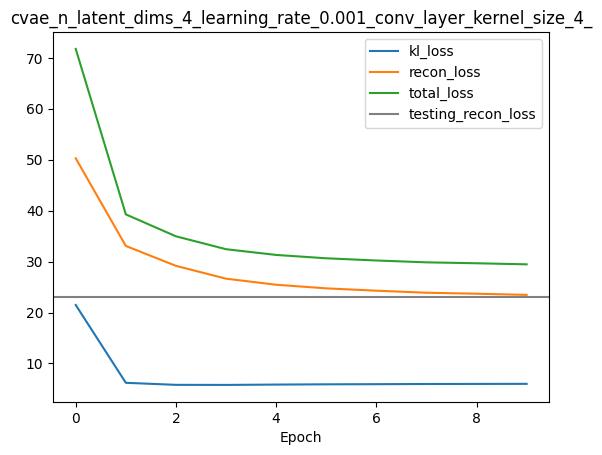

In [14]:
# Plot the training curves for the model
fig, ax = plt.subplots()

for loss_name in ['kl_loss', 'recon_loss', 'total_loss']:
    if loss_name in logs.history.keys():
        loss_values = logs.history[loss_name]
        x = np.arange(len(loss_values))
        ax.plot(x, loss_values, label=loss_name)
loss_values = logs.history['evaluation_results']['recon_loss']
ax.axhline(y=loss_values, xmin=0, xmax=nEpochs, label='testing_recon_loss', color='gray')
        
ax.legend()
ax.set_xlabel('Epoch')
ax.set_title(model_name)

In [ ]:

# Assuming you are using the provided callbacks and save the model/outputs appropriately,
# You should be able to use the provided `image_viewer` to look at the fakes and/or recons just by
# Passing in a model's name/directory.


In [7]:
def load_pkl(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data


In [8]:
output_base_dir

'outputs/hpo_cvae_gridSearch'

In [11]:

from tqdm import tqdm

metrics_dict = {}
for expr in tqdm(os.listdir(output_base_dir)):
    if not expr.startswith('optimal'):
        metrics_dict[expr] = load_pkl(f'{output_base_dir}/{expr}/{expr}.logs')


100%|██████████| 11/11 [00:00<00:00, 2233.93it/s]


Text(0.5, 1.0, 'training total loss')

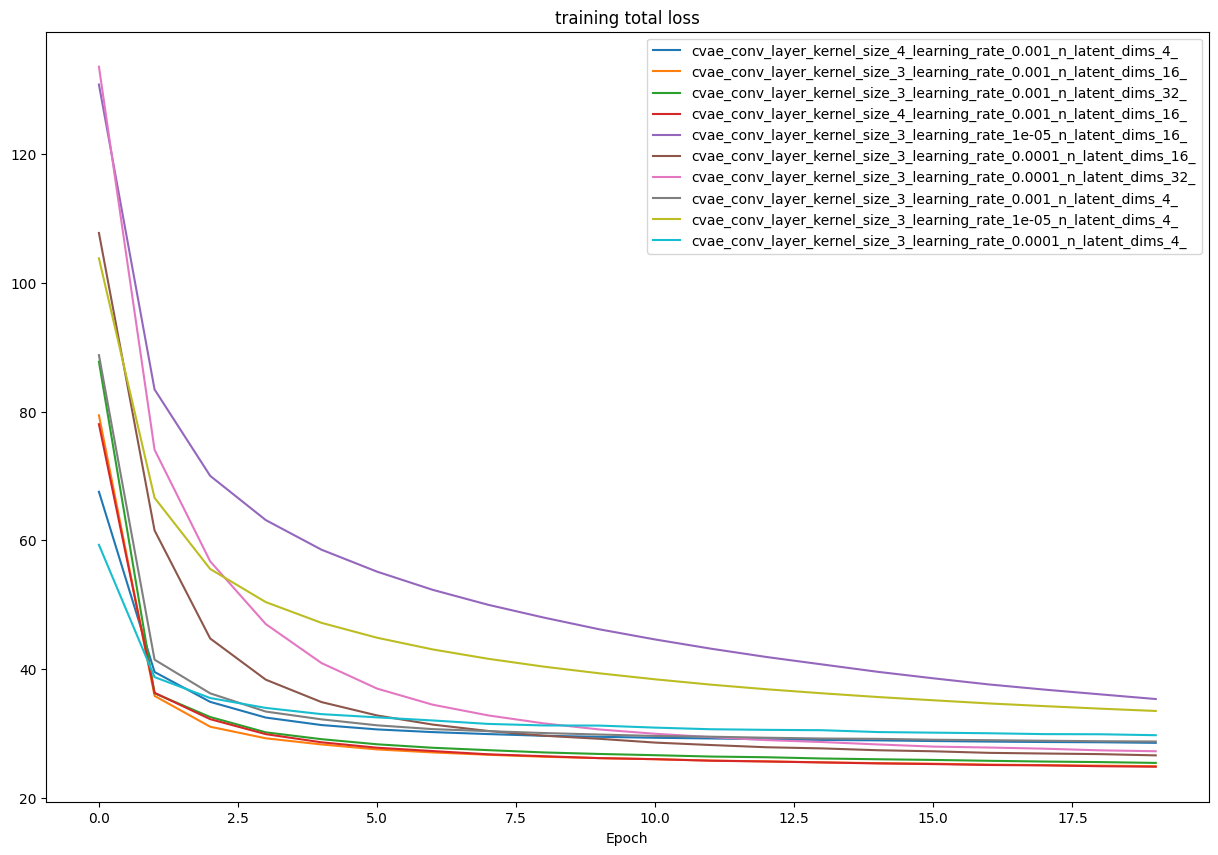

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))

for expr in metrics_dict.keys():
    loss_values = metrics_dict[expr]['total_loss']
    x = np.arange(len(loss_values))
    ax.plot(x, loss_values, label=expr)
       
ax.legend()
ax.set_xlabel('Epoch')
ax.set_title('training total loss')

In [ ]:
import pandas as pd
img = pd.DataFrame()
img.index = metrics_dict.keys()
for los in ['total_loss', 'recon_loss', 'kl_loss']:
    img[los] = [metrics_dict[item]['evaluation_results'][los] for item in img.index]
img = img.stack().reset_index()
img.columns = ['experiment', 'loss_value', 'loss_scores']
img['mark'] = [f'{parts[5]}_{parts[8]}_{parts[12]}' for parts in (item.split('_') for item in img.experiment)]

<Axes: xlabel='mark', ylabel='loss_scores'>

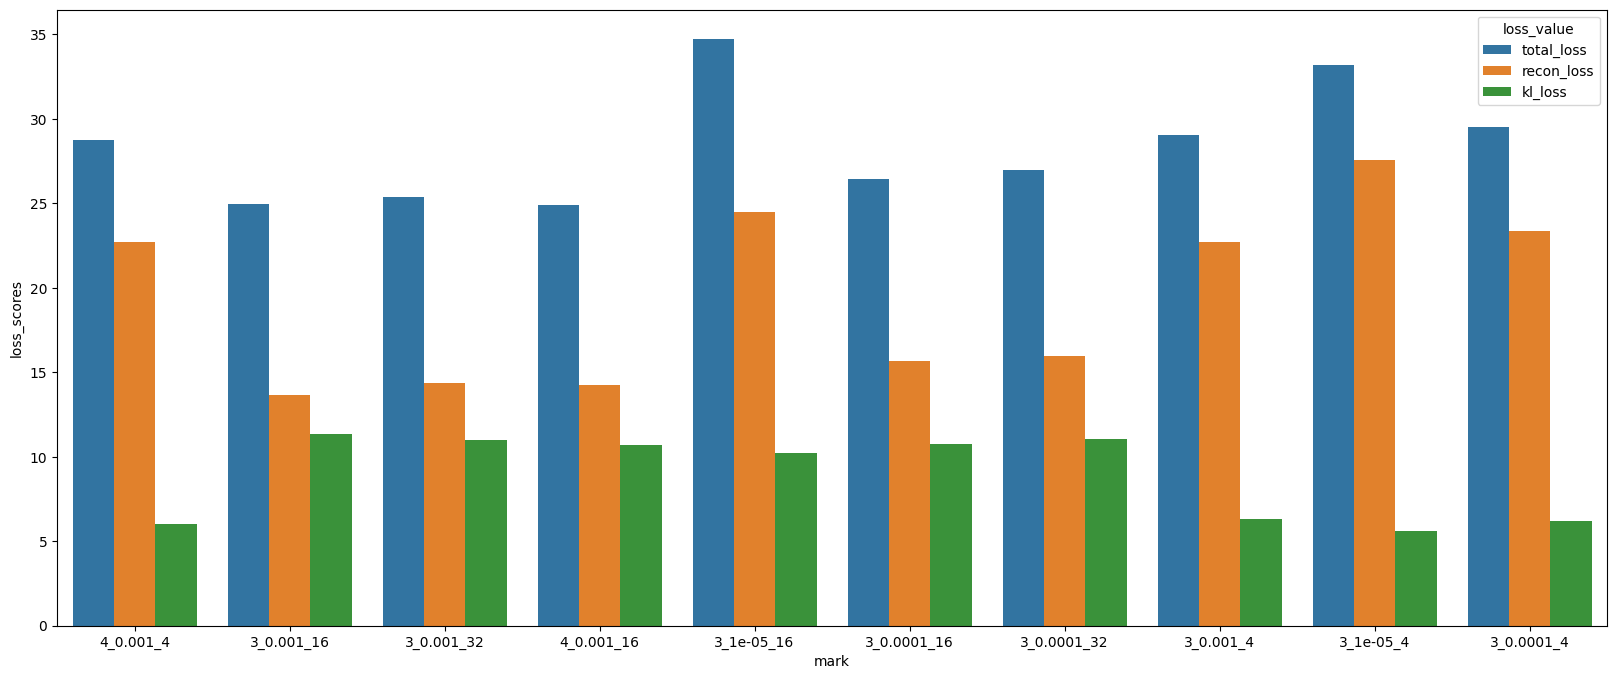

In [33]:
import seaborn as sns

plt.figure(figsize=(20, 8))
sns.barplot(data=img, x='mark', y='loss_scores', hue='loss_value')

I meant to tune 3 parameters: n_latent_dim, learning_rate, and convolution kernel size. n_latent_dim and kernel size are related to model learning performance and speed, and learning rate controls the gradient descend performance. I tried learning_rate=1e-2 but the model collapsed, so I tried 1e-3 -> 1e-5, looks like 1e-3 is an optimal choice, wrt n_latent_dims, n_latent_dims = 4 seems to be a choice, and I checked the reconstructed images it looks reasonbale too, but the latent space don't cluster well based on tsne visualizations, so I'm still trying to find an optimal values. I am still waiting for different kernel_size results, but looks like it doesn't change much if we compare combination (4, 0.001, 4) and (3, 0.001, 4).